In [1]:
import numpy as np
import glob
import xarray as xr
import pandas as pd
import time, datetime, calendar, pytz
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from copy import copy
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
# cmipdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/data4paper/'
datadir = '/project/projectdirs/m1660/www/yang560/IRI_MCS/fig6/'
cmipfile = f'{datadir}pr.tas.JJA.cmip5amip.bias.nc'

# prismfile = f'/global/project/projectdirs/m1657/zfeng/usa/wrf/data4paper/prism_avgT.nc'
# wrfprismfile = f'/global/project/projectdirs/m1657/zfeng/usa/wrf/data4paper/wrf_avgT.nc'
prismfile = f'{datadir}prism_avgT.nc'
wrfprismfile = f'{datadir}wrf_avgT.nc'

# wrfdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/data4paper/sig_0.05/'
# wrffile = f'{wrfdir}t2_sig_2011-2012_6xdaily.nc'
wrffile = f'{datadir}t2_sig_2011-2012_6xdaily.nc'

# wrflandmaskfile = '/global/project/projectdirs/m1657/zfeng/usa/wrf/map_data/wrf_irrig_grid.nc'
# narrfile = '/global/project/projectdirs/m2689/zhefeng/narr/map_data/hgt.sfc.nc'
wrflandmaskfile = f'{datadir}wrf_irrig_grid.nc'

# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/results/'
# figdir = '/global/project/projectdirs/m1657/zfeng/usa/wrf/figures4paper/'
figdir = datadir

In [3]:
dscmip = xr.open_dataset(cmipfile)
lon_cmip = dscmip.longitude
lat_cmip = dscmip.latitude
dscmip

<xarray.Dataset>
Dimensions:           (bound: 2, latitude: 36, longitude: 66)
Coordinates:
  * latitude          (latitude) float32 20.0 21.0 22.0 23.0 ... 53.0 54.0 55.0
  * longitude         (longitude) float32 230.0 231.0 232.0 ... 294.0 295.0
Dimensions without coordinates: bound
Data variables:
    bounds_latitude   (latitude, bound) float64 ...
    bounds_longitude  (longitude, bound) float64 ...
    pr                (latitude, longitude) float32 ...
    tas               (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.0

In [4]:
# Read PRISM T2 data
dspsm = xr.open_dataset(prismfile)
lon_psm = dspsm.lon2d.isel(lat=0)
lat_psm = dspsm.lat2d.isel(lon=0)
dspsm = dspsm.assign_coords({"lon":(lon_psm), "lat":(lat_psm)})
dspsm

<xarray.Dataset>
Dimensions:    (lat: 87, lon: 196)
Coordinates:
  * lon        (lon) float64 -125.0 -124.7 -124.4 ... -67.12 -66.82 -66.52
  * lat        (lat) float64 24.06 24.36 24.66 24.96 ... 48.96 49.26 49.56 49.86
Data variables:
    lon2d      (lat, lon) float64 ...
    lat2d      (lat, lon) float64 ...
    prism_avg  (lat, lon) float64 ...

In [5]:
# Read WRF T2 data regridded to PRISM grid
dswrfpsm = xr.open_dataset(wrfprismfile)
dswrfpsm = dswrfpsm.rename({'ncl0':'lat', 'ncl1':'lon', 'ncl2':'lat', 'ncl3':'lon'})
dswrfpsm = dswrfpsm.assign_coords({"lon":(lon_psm), "lat":(lat_psm)})
dswrfpsm

<xarray.Dataset>
Dimensions:   (lat: 87, lon: 196)
Coordinates:
  * lon       (lon) float64 -125.0 -124.7 -124.4 -124.1 ... -67.12 -66.82 -66.52
  * lat       (lat) float64 24.06 24.36 24.66 24.96 ... 48.96 49.26 49.56 49.86
Data variables:
    irrg_avg  (lat, lon) float32 ...
    ctrl_avg  (lat, lon) float32 ...
    lat1d     (lat) float32 ...
    lon1d     (lon) float32 ...

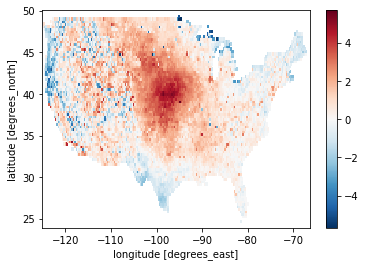

In [6]:
# Calculate WRF T2 bias
t2bias_ctl = (dswrfpsm.ctrl_avg - 273.15) - dspsm.prism_avg
t2bias_ctl.plot()

In [7]:
# Read WRF landmask file
dswrflm = xr.open_dataset(wrflandmaskfile)
lon_wrf = dswrflm.longitude
lat_wrf = dswrflm.latitude
# dswrflm

In [8]:
# Read WRF T2 difference file
dswrf = xr.open_dataset(wrffile)
# Rename the dimensions
# dswrf.rename({'ncl0':'south_north', 'ncl1':'west_east', 'ncl2':'south_north', 'ncl3':'west_east'}, inplace=True)
dswrf = dswrf.rename({'ncl0':'lat', 'ncl1':'lon', 'ncl2':'lat', 'ncl3':'lon', 'south_north':'lat', 'west_east':'lon'})
dswrf

<xarray.Dataset>
Dimensions:    (lat: 810, lon: 1404)
Dimensions without coordinates: lat, lon
Data variables:
    t2_diff    (lat, lon) float32 ...
    t2_sig     (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
Attributes:
    history:  Wed Apr 24 09:04:48 2019: ncrename -v lon,longitude t2_sig_2011...
    NCO:      netCDF Operators version 4.7.4 (http://nco.sf.net)

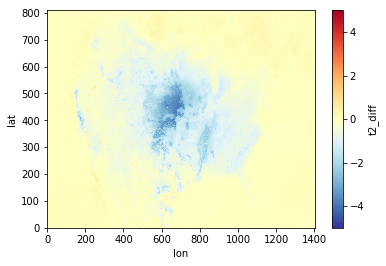

In [9]:
# dswrf.t2_diff.where(dswrf.t2_sig == 1).plot(vmin=-5, vmax=5, cmap='bwr')
dswrf.t2_diff.plot(vmin=-5, vmax=5, cmap='RdYlBu_r')

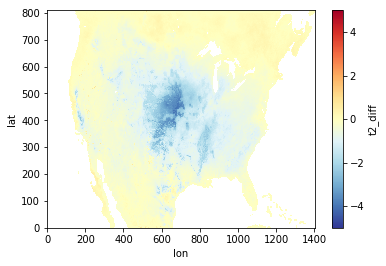

In [10]:
# Filter T2 difference over water using landmask
t2_diff = dswrf.t2_diff.where(dswrflm.LANDMASK == 1)
t2_sig = dswrf.t2_sig

t2_diff.plot(vmin=-5, vmax=5, cmap='RdYlBu_r')

In [11]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [12]:
def plot_map_3panels(dataarr, lonarr, latarr, sigarr, levels, cmaps, titles, cblabels, cbticks, figname):

    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    map_extend = [-120.1, -70, 22., 50.1]
    lonv = list(np.arange(-175,-5.1,10))
    latv = list(np.arange(20,61,5))
    lonvals = mpl.ticker.FixedLocator(lonv)
    latvals = mpl.ticker.FixedLocator(latv)
    proj = ccrs.LambertConformal()
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
#     lakes = cfeature.NaturalEarthFeature('physical', 'lakes', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', 
                                          scale='50m', facecolor='none')

    fig = plt.figure(figsize=[10,17], dpi=100)
    gs = gridspec.GridSpec(3,1, height_ratios=[1,1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.87, hspace=0.1)

    for pp in range(0,3):
        ax = plt.subplot(gs[pp], projection=proj)
#         ax = plt.subplot(3,1,pp+1, projection=proj)
        ax.set_extent(map_extend, crs=ccrs.Geodetic())
#         ax.add_feature(land, facecolor='lightgray')
        ax.add_feature(ocean, edgecolor='k', facecolor='none')
        ax.add_feature(states, linewidth=1, edgecolor='k', facecolor='none', zorder=3)
        ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=3)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        ax.set_title(titles[pp], loc='left')
        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = lonvals
        gl.ylocator = latvals
        # Label the end-points of the gridlines using the custom tick makers:
        ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
        if (pp == 2):
            lambert_xticks(ax, lonv)
        lambert_yticks(ax, latv)

        cmap = plt.get_cmap(cmaps[pp])
        norm = mpl.colors.BoundaryNorm(levels[pp], ncolors=cmap.N, clip=True)
        Zm = np.ma.masked_where(np.isnan(dataarr[pp]), dataarr[pp])
        cf1 = plt.pcolormesh(lonarr[pp], latarr[pp], Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
        # Hash significance
        if (pp == 2):
            ct1 = plt.contourf(lonarr[pp], latarr[pp], sigarr, [0.9, 1.0], colors='none', hatches=['//',None], transform=ccrs.PlateCarree(), zorder=2)
#         cb1 = plt.colorbar(cf1, label=cblabels[pp], pad=0.03, ticks=cbticks[pp], extend='both')

    # Plot 1 colorbar by manually adding a new axes
    cax1 = fig.add_axes([0.90, 0.2, 0.03, 0.6])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='vertical', extend='both')
    cb1.set_label(cblabels[0], fontsize=18)
    cb1.ax.tick_params(labelsize=18)

#     plt.tight_layout(h_pad=0.12, w_pad=0.1)
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    return fig

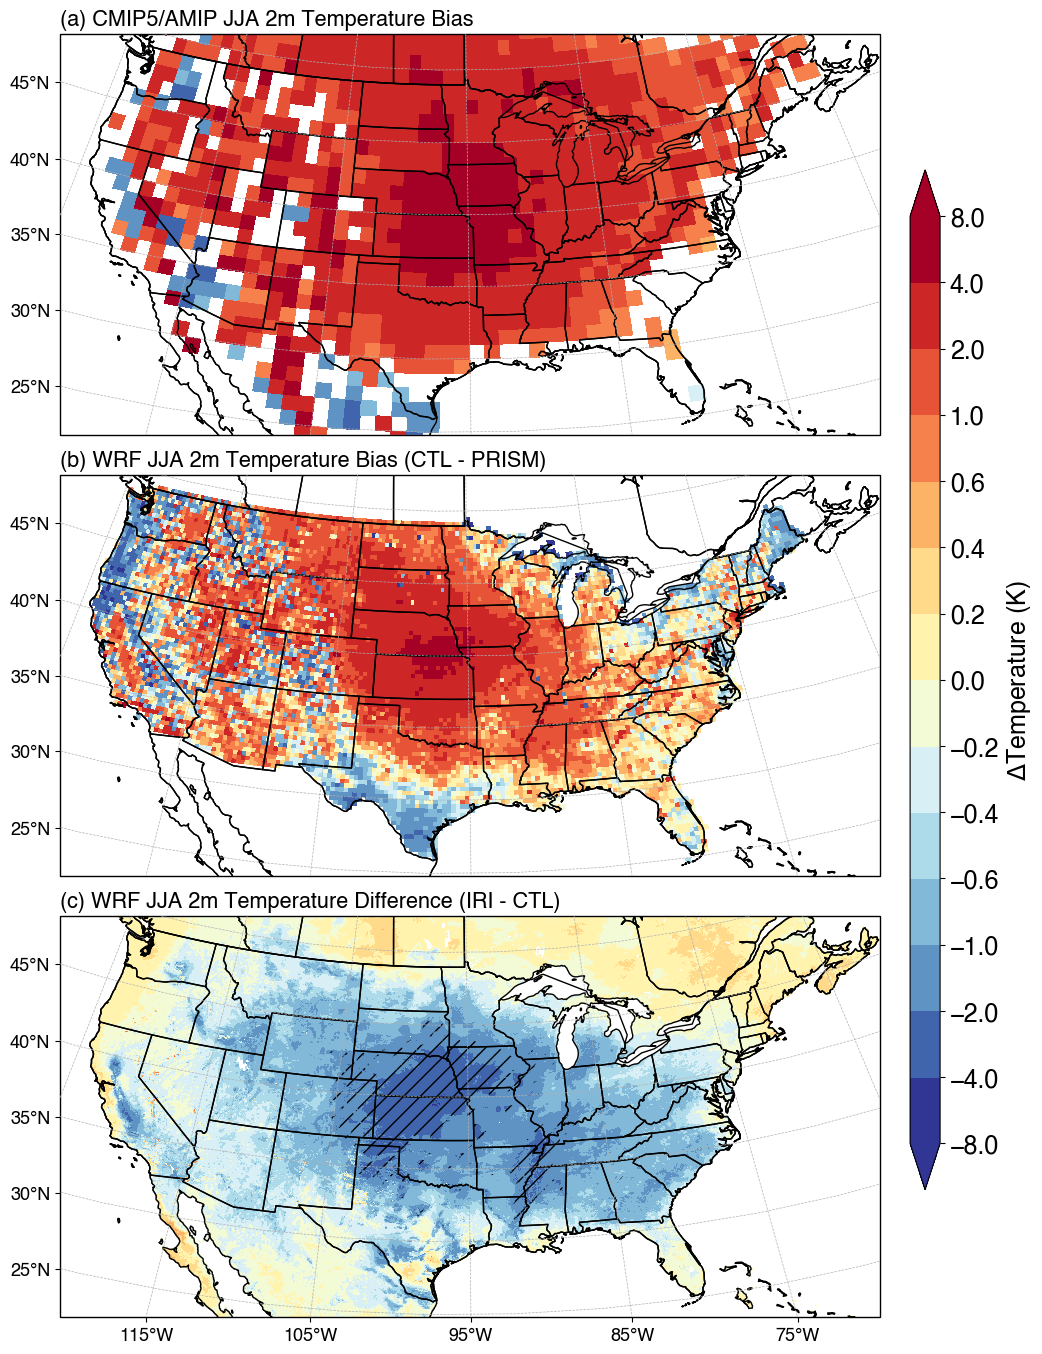

In [13]:
dataarr = [dscmip.tas, t2bias_ctl, t2_diff]
lonarr = [lon_cmip, lon_psm, lon_wrf]
latarr = [lat_cmip, lat_psm, lat_wrf]
levels = [-8,-4,-2,-1,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,1,2,4,8]
levelsarr = [levels, levels, levels]
cbticks = [levels, levels, levels]
cmaps = ['RdYlBu_r','RdYlBu_r','RdYlBu_r']
titles = ['(a) CMIP5/AMIP JJA 2m Temperature Bias',
           '(b) WRF JJA 2m Temperature Bias (CTL - PRISM)',
           '(c) WRF JJA 2m Temperature Difference (IRI - CTL)']
# titles2 = ['JJA (IRI - CTL)', '', '']
cblabels = ['$\Delta$Temperature (K)','$\Delta$Temperature (K)','$\Delta$Temperature (K)']
figname = f'{figdir}cmip5_wrf_wrfdiff_T2_compare.png'
# figname = f'{figdir}cmip5_wrf_wrfdiff_T2_compare.pdf'
fig = plot_map_3panels(dataarr, lonarr, latarr, t2_sig, levelsarr, cmaps, titles, cblabels, cbticks, figname)

In [14]:
figname

'/project/projectdirs/m1660/www/yang560/IRI_MCS/fig6/cmip5_wrf_wrfdiff_T2_compare.png'

In [15]:
# mpl.rcParams['font.size'] = 12
# mpl.rcParams['font.family'] = 'Helvetica'
# map_extend = [-120.1, -70, 22., 50.1]
# lonv = list(np.arange(-175,-5.1,10))
# latv = list(np.arange(20,61,5))
# lonvals = mpl.ticker.FixedLocator(lonv)
# latvals = mpl.ticker.FixedLocator(latv)
# proj = ccrs.LambertConformal()
# resolution = '50m'
# land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
# ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
# borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
# states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', 
#                                       scale='50m', facecolor='none')
# fig = plt.figure(figsize=[15,5], dpi=100)
# gs = gridspec.GridSpec(1,4, height_ratios=[0.5], width_ratios=[1,1,0,0.03])
# gs.update(left=0.05, right=0.95, wspace=0.05)
# # cmap = 'bwr'
# # levels = np.arange(-5,5.1,1)
# cmap = 'RdYlBu_r'
# levels = [-8,-4,-2,-1,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,1,2,4,8]

# ax = plt.subplot(gs[0], projection=proj)
# ax.set_extent(map_extend, crs=ccrs.Geodetic())
# ax.add_feature(states, linewidth=1, edgecolor='k', facecolor='none', zorder=5)
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=5)
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
# ax.set_aspect('auto', adjustable=None)
# ax.set_title('(a) CMIP5/AMIP JJA 2m Temperature Bias', loc='left')
# # *must* call draw in order to get the axis boundary used to add ticks:
# fig.canvas.draw()
# gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = lonvals
# gl.ylocator = latvals
# # Label the end-points of the gridlines using the custom tick makers:
# ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
# ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax, lonv)
# lambert_yticks(ax, latv)

# cmap = plt.get_cmap(cmap)
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Zm = np.ma.masked_where(np.isnan(dscmip.tas), dscmip.tas)
# cf1 = plt.pcolormesh(dscmip.longitude, dscmip.latitude, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)


# ax = plt.subplot(gs[1], projection=proj)
# ax.set_extent(map_extend, crs=ccrs.Geodetic())
# ax.add_feature(states, linewidth=1, edgecolor='k', facecolor='none', zorder=5)
# ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=5)
# ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
# ax.set_aspect('auto', adjustable=None)
# ax.set_title('(b) WRF JJA 2m Temperature Difference (IRI - CTL)', loc='left')
# # *must* call draw in order to get the axis boundary used to add ticks:
# fig.canvas.draw()
# gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = lonvals
# gl.ylocator = latvals
# # Label the end-points of the gridlines using the custom tick makers:
# ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
# ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax, lonv)
# # lambert_yticks(ax, latv)

# cmap = plt.get_cmap(cmap)
# norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Zm = np.ma.masked_where(np.isnan(dswrf.t2_diff), dswrf.t2_diff)
# cf2 = plt.pcolormesh(dswrf.longitude, dswrf.latitude, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
# ct2 = plt.contourf(dswrf.longitude, dswrf.latitude, dswrf.t2_sig, [0.9, 1.0], colors='none', hatches=['//',None], transform=ccrs.PlateCarree(), zorder=2)

# # Colorbar
# cax1 = plt.subplot(gs[3])
# cb1 = plt.colorbar(cf1, cax=cax1, label='$\Delta$Temperature (K)', ticks=levels, extend='both')

# fig.savefig(f'{figdir}cmip5_wrf_T2_compare.png', dpi=300, bbox_inches='tight')

In [16]:
figdir

'/project/projectdirs/m1660/www/yang560/IRI_MCS/fig6/'

In [17]:
# def plot_map(dataarr, levels, cmaps, titles1, titles2, cblabels, cbticks, figname):

#     mpl.rcParams['font.size'] = 12
#     mpl.rcParams['font.family'] = 'Helvetica'
#     map_extend = [-120.1, -70, 22., 50.1]
#     lonv = list(np.arange(-175,-5.1,10))
#     latv = list(np.arange(20,61,5))
#     lonvals = mpl.ticker.FixedLocator(lonv)
#     latvals = mpl.ticker.FixedLocator(latv)
#     proj = ccrs.LambertConformal()
#     resolution = '50m'
#     land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
#     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
# #     lakes = cfeature.NaturalEarthFeature('physical', 'lakes', resolution)
#     borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
#     states = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', 
#                                           scale='50m', facecolor='none')
#     fig = plt.figure(figsize=[10,5], dpi=100)

# #     for pp in range(0,3):
# #         ax = plt.subplot(1, 3, pp+1, projection=proj)
#     pp = 0
#     ax = plt.subplot(projection=proj)
#     ax.set_extent(map_extend, crs=ccrs.Geodetic())
# #     ax.add_feature(land, facecolor='none')
# #     ax.add_feature(ocean, edgecolor='k', facecolor='none')
#     ax.add_feature(states, linewidth=1, edgecolor='k', facecolor='none', zorder=5)
#     ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=1, zorder=5)
#     ax.add_feature(land, facecolor='none', edgecolor='k', zorder=5)
#     ax.set_aspect('auto', adjustable=None)
#     ax.set_title(titles1[pp], loc='left')
#     ax.set_title(titles2[pp], loc='right')

#     # *must* call draw in order to get the axis boundary used to add ticks:
#     fig.canvas.draw()
#     gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, zorder=5)
#     gl.xlabels_top = False
#     gl.ylabels_right = False
#     gl.xlocator = lonvals
#     gl.ylocator = latvals
#     # Label the end-points of the gridlines using the custom tick makers:
#     ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#     ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
#     lambert_xticks(ax, lonv)
# #     if (pp == 0):
#     lambert_yticks(ax, latv)
    
# #     # Terrain height
# #     levelshgt = [1000,2000]
# #     ct = ax.contour(lon_ter, lat_ter, ter_s, levels=levelshgt, \
# #                     colors='magenta', linewidths=1, transform=ccrs.PlateCarree(), zorder=6)
# #     ctlb = ax.clabel(ct, inline=True, fmt='%.0f', fontsize=12)

#     cmap = plt.get_cmap(cmaps[pp])
#     norm = mpl.colors.BoundaryNorm(levels[pp], ncolors=cmap.N, clip=True)
#     Zm = np.ma.masked_where(np.isnan(dataarr[pp]), dataarr[pp])
# #     Zm = np.ma.masked_where(((landmask == 0)), Zm)
#     cf1 = plt.pcolormesh(lon, lat, Zm, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
#     cb1 = plt.colorbar(cf1, label=cblabels[pp], pad=0.03, ticks=cbticks[pp], extend='both')

#     plt.tight_layout(h_pad=0.8, w_pad=0.2)
#     fig.savefig(figname, dpi=300, bbox_inches='tight')
#     return fig

In [18]:
# dataarr = [ds.tas]
# levels = [np.arange(-5, 5.01, 1)]
# cbticks = [np.arange(-5, 5.01, 1)]
# cmaps = ['bwr']
# titles1 = ['CMIP5/AMIP (1979-2005) JJA 2m Temperature Bias']
# titles2 = ['']
# cblabels = ['Temperature Bias (K)']
# figname = f'{figdir}cmip5_T2_bias.png'
# fig = plot_map(dataarr, levels, cmaps, titles1, titles2, cblabels, cbticks, figname)

In [19]:
# dataarr = [ds.pr]
# levels = [np.arange(-2, 2.01, 0.5)]
# cbticks = [np.arange(-2, 2.01, 0.5)]
# cmaps = ['BrBG']
# titles1 = ['CMIP5/AMIP (1979-2005) JJA Precipitation Bias']
# titles2 = ['']
# cblabels = ['Precipitation Bias (mm day$^{-1}$)']
# figname = f'{figdir}cmip5_precip_bias.png'
# fig = plot_map(dataarr, levels, cmaps, titles1, titles2, cblabels, cbticks, figname)